<a href="https://colab.research.google.com/github/nattntn/15-23yrs_EffNet/blob/main/Multi-Task_Duo/Train/15_23_12_Eff_Multi_Train_500Freeze_Unflipped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import shutil

In [ ]:
#เชื่อม google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline
import datetime

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

#กำหนดค่าพารามิเตอร์


In [ ]:
batch_size = 16
width = 224 # จตุรัส โมเตลจะเรียนรู้ภาพได้ดีที่สุด
height = 224
epochs = 500 # รอบในการเทรน
dropout_rate = 0.2
input_shape = (height, width, 3)

#Clone efficientnet repo


In [ ]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 14.38 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [ ]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

# load model

In [ ]:
import sys
sys.path.append('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(15-23)/11_Multi_1e-4_500_Freeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [ ]:
#load model
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(15-23)/11_Multi_1e-4_500_Freeze.h5')
height = width = model.input_shape[1]


In [ ]:
model.summary()

Model: "EffNet_Multi-task"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 112, 112, 32)         0         ['batch_normal

#สร้างโฟลเดอร์ Train Valodation และ Test

In [ ]:
df = pd.read_csv (r'/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(15-23)/table_train_15_23_Gender.csv')
df

,Unnamed: 0,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,1833,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B07.jpg,9,0
1,1834,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB07.jpg,7,0
2,1835,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B08.jpg,5,0
3,1836,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB08.jpg,10,0
4,1837,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B18.jpg,8,0
...,...,...,...,...,...,...,...,...,...
1947,3780,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
1948,3781,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
1949,3782,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
1950,3783,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [ ]:
df = df.iloc[:,1:]

In [ ]:
val = df[df['Fold']==3]
val

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
11,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB32.jpg,3,0
15,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB38.jpg,3,0
19,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB56.jpg,3,0
47,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB103.jpg,3,0
48,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B108.jpg,3,0
...,...,...,...,...,...,...,...,...
1874,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E146.jpg,3,1
1902,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E306.jpg,3,1
1919,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE387.jpg,3,1
1942,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E423.jpg,3,1


In [ ]:
train = df[~df['Fold'].isin(val['Fold'])]
train

,Age(year),Gender,Folder_type,Folder_name,Path_Name,Filename,Fold,Gender_Class
0,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B07.jpg,9,0
1,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB07.jpg,7,0
2,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B08.jpg,5,0
3,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipB08.jpg,10,0
4,15,F,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,B18.jpg,8,0
...,...,...,...,...,...,...,...,...
1947,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE429.jpg,10,1
1948,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E430.jpg,6,1
1949,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,FlipE430.jpg,10,1
1950,23,M,Normal,Both,/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_to...,E431.jpg,10,1


In [ ]:
DATA_PATH = "/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Data_Cut_images/Normal"
os.chdir(DATA_PATH)
#train_dir = os.path.join(DATA_PATH, 'train')
#print(train_dir)
#validation_dir = os.path.join(DATA_PATH, 'validation')
#print(validation_dir)


#Train

In [ ]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      # horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = ['Age(year)','Gender_Class'],
        class_mode = 'multi_output',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

validation_generator = test_datagen.flow_from_dataframe(
        dataframe = val,
        directory = DATA_PATH,
        x_col = 'Path_Name',
        y_col = ['Age(year)','Gender_Class'],
        class_mode = 'multi_output',
        color_mode= 'rgb',
        target_size=(height, width),
        batch_size=batch_size)

Found 1757 validated image filenames.
Found 195 validated image filenames.


In [ ]:
model.output_names

['Prediction_Age', 'Prediction_Gender']

In [ ]:
model.compile(
   loss={'Prediction_Age': 'mse', 'Prediction_Gender': 'binary_crossentropy'},
   loss_weights={'Prediction_Age': 0.75, 'Prediction_Gender': 0.25},
   optimizer= Adam(learning_rate=1e-5),
   metrics={'Prediction_Age': ['mse'], 'Prediction_Gender': ['accuracy']}
   )

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= len(train) //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= len(val) //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-21-4a1ce764999b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/500
109/109 [==============================] - 410s 4s/step - loss: 1.8413 - Prediction_Age_loss: 2.3416 - Prediction_Gender_loss: 0.3403 - Prediction_Age_mse: 2.3416 - Prediction_Gender_accuracy: 0.8535 - val_loss: 2.5306 - val_Prediction_Age_loss: 3.2673 - val_Prediction_Gender_loss: 0.3204 - val_Prediction_Age_mse: 3.2673 - val_Prediction_Gender_accuracy: 0.8698
Epoch 2/500
109/109 [==============================] - 16s 140ms/step - loss: 1.9334 - Prediction_Age_loss: 2.4620 - Prediction_Gender_loss: 0.3475 - Prediction_Age_mse: 2.4620 - Prediction_Gender_accuracy: 0.8656 - val_loss: 2.5615 - val_Prediction_Age_loss: 3.3088 - val_Prediction_Gender_loss: 0.3194 - val_Prediction_Age_mse: 3.3088 - val_Prediction_Gender_accuracy: 0.8698
Epoch 3/500
109/109 [==============================] - 15s 138ms/step - loss: 1.8803 - Prediction_Age_loss: 2.3918 - Prediction_Gender_loss: 0.3461 - Prediction_Age_mse: 2.3918 - Prediction_Gender_accuracy: 0.8507 - val_loss: 2.4774 - val_Predict

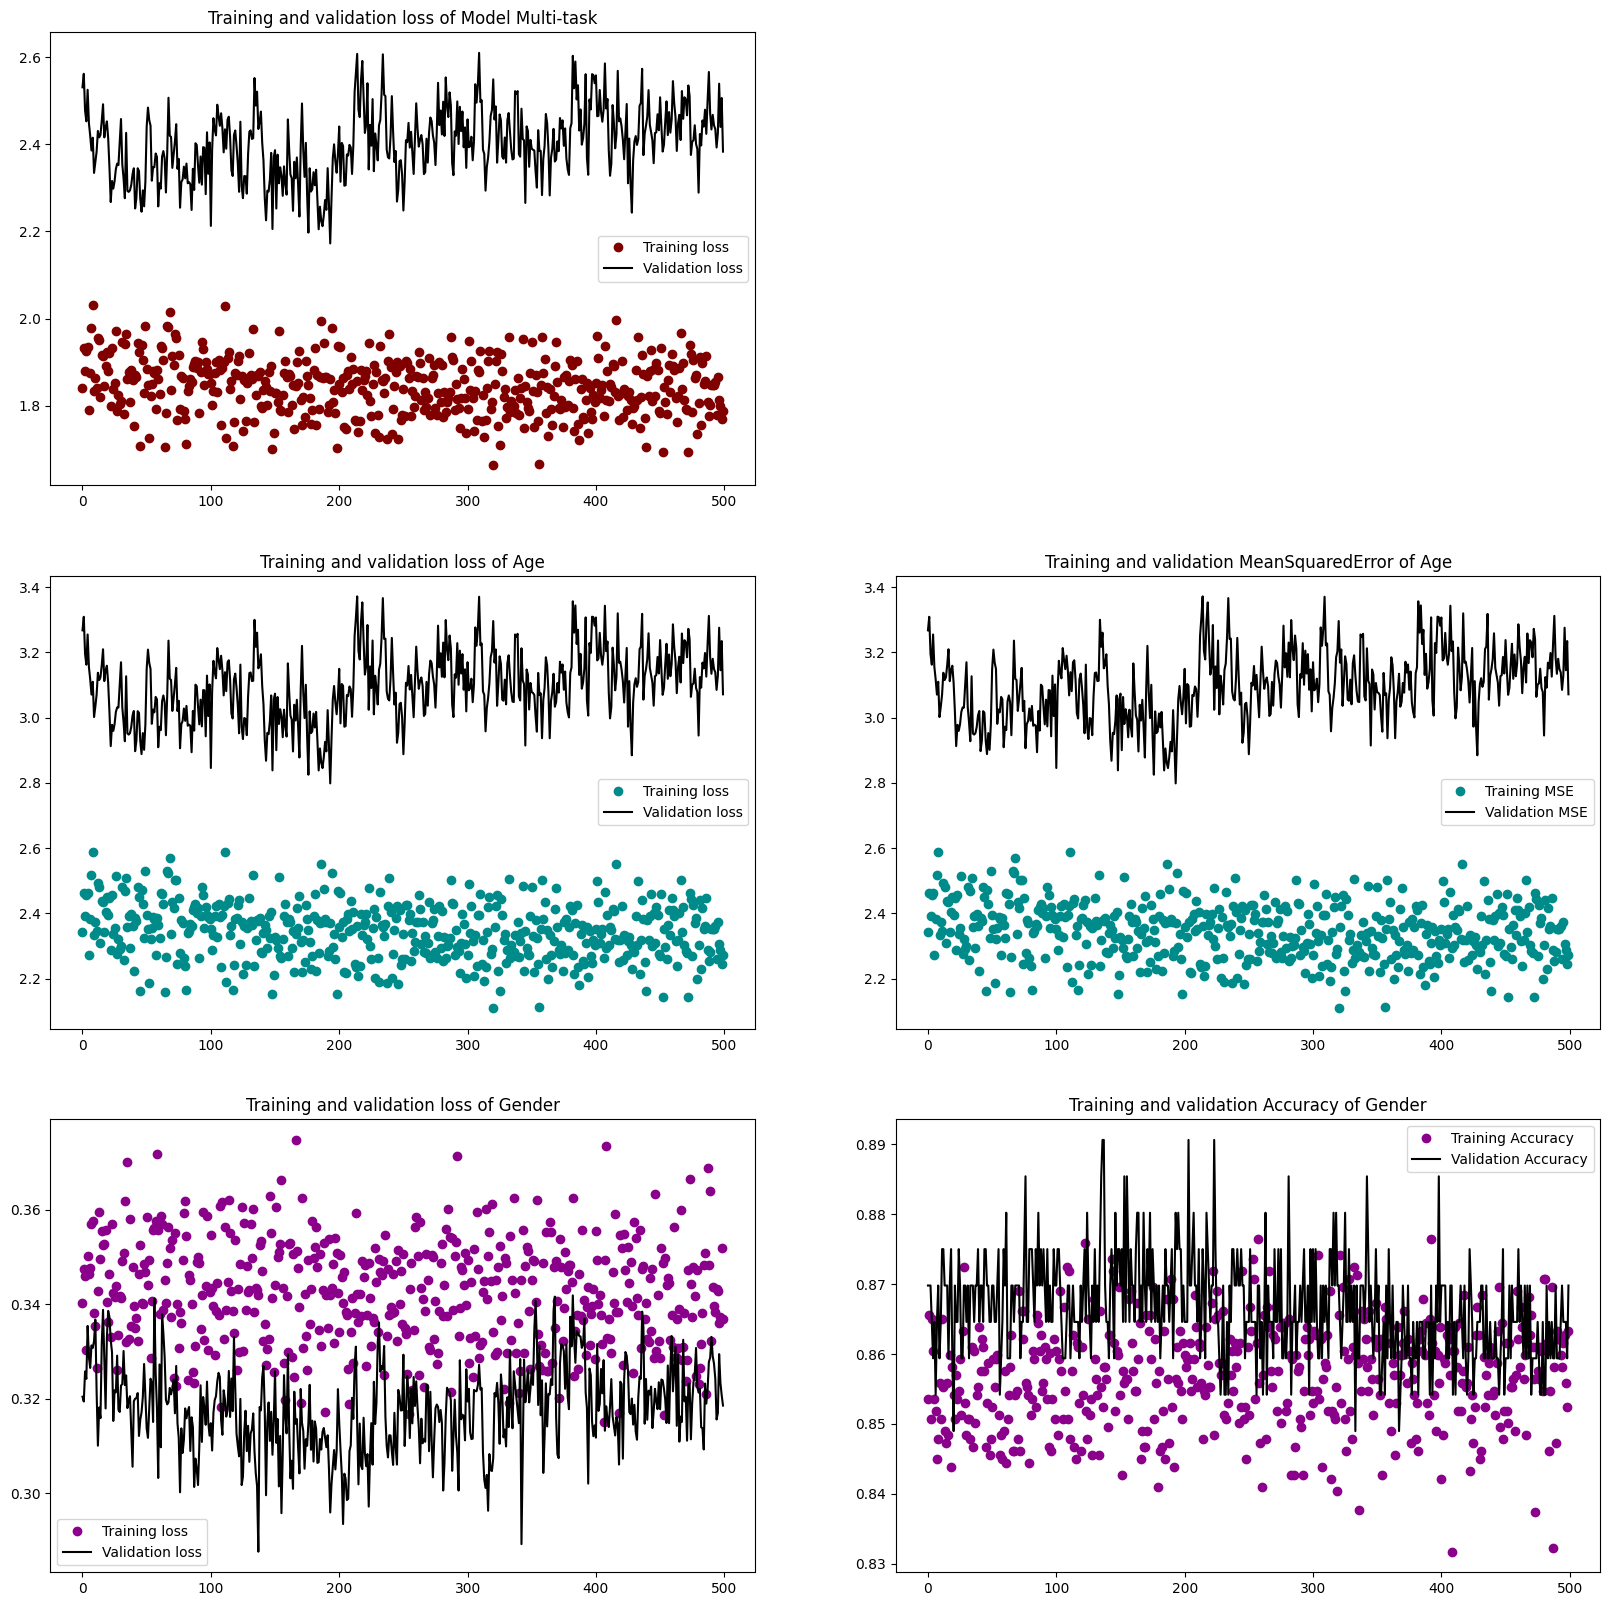

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

loss_age = history.history['Prediction_Age_loss']
val_loss_age = history.history['val_Prediction_Age_loss']

loss_gender = history.history['Prediction_Gender_loss']
val_loss_gender = history.history['val_Prediction_Gender_loss']

mse_age = history.history['Prediction_Age_mse']
val_mse_age = history.history['val_Prediction_Age_mse']

acc_gender = history.history['Prediction_Gender_accuracy']
val_acc_gender = history.history['val_Prediction_Gender_accuracy']


epochs_x = range(len(loss))
# plt.figure(10,20)
from matplotlib import pyplot as plt #เพื่อ plot graph
import matplotlib #เพื่อปรับแต่งขนาดของกราฟ
matplotlib.rcParams['figure.figsize']=[20,20]

# loss val_loss
plt.subplot(3,2,1)
plt.plot(epochs_x, loss, 'o', color ='maroon', label='Training loss')
plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
plt.title('Training and validation loss of Model Multi-task')
plt.legend()
#------------------------------------------------------------------
# age
plt.subplot(3,2,3)
plt.plot(epochs_x, loss_age, 'o', color ='darkcyan', label='Training loss')
plt.plot(epochs_x, val_loss_age, 'k', label='Validation loss')
plt.title('Training and validation loss of Age')
plt.legend()

plt.subplot(3,2,4)
plt.plot(epochs_x, mse_age, 'o', color ='darkcyan', label='Training MSE')
plt.plot(epochs_x, val_mse_age, 'k', label='Validation MSE')
plt.title('Training and validation MeanSquaredError of Age')
plt.legend()
#------------------------------------------------------------------
# gender
plt.subplot(3,2,5)
plt.plot(epochs_x, loss_gender, 'o', color ='darkmagenta', label='Training loss')
plt.plot(epochs_x, val_loss_gender, 'k', label='Validation loss')
plt.title('Training and validation loss of Gender')
plt.legend()

plt.subplot(3,2,6)
plt.plot(epochs_x, acc_gender, 'o', color ='darkmagenta', label='Training Accuracy')
plt.plot(epochs_x, val_acc_gender, 'k', label='Validation Accuracy')
plt.title('Training and validation Accuracy of Gender')
plt.legend()
#------------------------------------------------------------------

# # plt.plot(epochs_x, loss, 'go', label='Training loss')
# plt.plot(epochs_x, loss, 'o', color ='darkviolet', label='Training loss')
# plt.plot(epochs_x, val_loss, 'k', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

plt.show()

In [ ]:
epochs_x

range(0, 500)

#Download the model


In [ ]:
os.makedirs('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model', exist_ok=True)
model.save('/content/gdrive/MyDrive/Tooth_Shap_GPT/Deep_tooth/Model/Unflipped_Multi_task(15-23)/12_Multi_1e-5_500_Freeze.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
